In [1]:
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline

In [2]:
def phase(x, m, b):
    return (m*x+b) % (2*np.pi) - np.pi

def lsq(data, model):
    return np.median((data - model)**2.0)

def rechannelize(pulse, nchan):
    pulse = np.fft.irfft(pulse, axis=1)
    # Reshape to channels and keep polarization
    
    if len(pulse.shape) == 3:
        pulse = pulse.reshape(-1, 2*nchan, pulse.shape[-1])
    else:
        pulse = pulse.reshape(-1, 2*nchan)
    pulse = np.fft.rfft(pulse, axis=1)
    return pulse

def dechannelize(pulse):
    pulse = np.fft.irfft(pulse, axis=1)
    if len(pulse.shape) == 3:
        pulse = pulse.reshape(-1, pulse.shape[-1])
    else:
        pulse = pulse.ravel()
    return pulse

def channelize_ts(pulse, nchan):
    if len(pulse.shape) == 2:
        pulse = pulse.reshape(-1, 2*nchan, pulse.shape[-1])
    else:
        pulse = pulse.reshape(-1, 2*nchan)
    pulse = np.fft.rfft(pulse, axis=1)
    return pulse

def correlate(p1, p2, cchan, fchan):
    p1fine = rechannelize(p1, fchan)
    p2fine = rechannelize(p2, fchan)
    p12_phased = (p1fine / abs(p1fine)) * (abs(p2fine) / p2fine)
    p12_phased = rechannelize(p12_phased, cchan)
    return p12_phased

def correlate_power(p1, p2, cchan, fchan):
    p1fine = rechannelize(p1, fchan)
    p2fine = rechannelize(p2, fchan)
    p12_phased = (p1fine) * (abs(p2fine) / p2fine)
    p12_phased = rechannelize(p12_phased, cchan)
    return p12_phased

def power(dchan):
    dR = np.concatenate((dchan[:,::-1,8], dchan[...,0], dchan[:,::-1,10], dchan[...,2], dchan[:,::-1,12], dchan[...,4], dchan[:,::-1,14], dchan[...,6]), axis=1)
    dL = np.concatenate((dchan[:,::-1,9], dchan[...,1], dchan[:,::-1,11], dchan[...,3], dchan[:,::-1,13], dchan[...,5], dchan[:,::-1,15], dchan[...,7]), axis=1)
    power = (abs(dR)**2 + abs(dL)**2)
    return power

def stitch(dchan):
    dR = np.concatenate((dchan[:,::-1,8], dchan[:,:,0], dchan[:,::-1,10], dchan[:,:,2], 
                         dchan[:,::-1,12], dchan[:,:,4], dchan[:,::-1,14], dchan[:,:,6]), axis=1)
    dL = np.concatenate((dchan[:,::-1,9], dchan[:,:,1], dchan[:,::-1,11], dchan[:,:,3], 
                         dchan[:,::-1,13], dchan[:,:,5], dchan[:,::-1,15], dchan[:,:,7]), axis=1)
    return dR, dL
    
def powerchan(dchan):
    R = np.array([8,0,10,2,12,4,14,6])
    L = np.array([9,1,11,2,13,5,15,7])
    dR = dchan[...,R]
    dL = dchan[...,L]
    power = abs(dR)**2.0 + abs(dL)**2.0
    return power

def normpower(pulse):
    p1temp = rechannelize(pulse, 256)
    power1 = abs(p1temp)**2.0
    power1 = power1[16] - power1[2:12].mean(axis=0)
    power1 = power1[32:-32]
    power1 = (power1 - power1.mean(axis=0)) / power1.std(axis=0)
    return power1
    

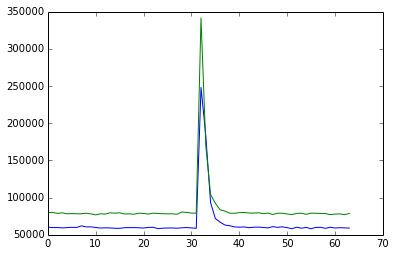

In [6]:
t_gp = '2015-10-19T00:17:47.415'
#t_gp = '2015-10-18T23:41:53.277'
#t_gp = '2015-10-18T23:39:46.844'

p1 = np.load('GPef/p%s.npy' % (t_gp))
p2 = np.load('GPjb/p%s.npy' % (t_gp))

m = np.mean(abs(p1).sum(-1).sum(-1)[:26])

plt.plot(abs(p1).sum(-1).sum(-1))
plt.plot(abs(p2).sum(-1).sum(-1))

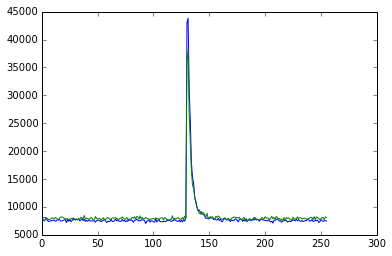

In [4]:
"""
Shift timestreams to closest sample

De-channelize, fit for corr peak, then shift
"""

nchan = 32

p1d = dechannelize(p1)
p2d = dechannelize(p2)

corr = np.fft.irfft( (np.fft.rfft(p1d,axis=0) * np.conj(np.fft.rfft(p2d, axis=0))), axis=0)
sampdelay = np.argmax(abs(corr).sum(-1))
p2d = np.roll(p2d, sampdelay, axis=0)

p2 = channelize_ts(p2d, nchan)
p1 = rechannelize(p1, nchan)

plt.plot(abs(p1).sum(-1).sum(-1))
plt.plot(abs(p2).sum(-1).sum(-1))

0.0818450991917 2.72906028494


(-6.283185307179586, 6.283185307179586)

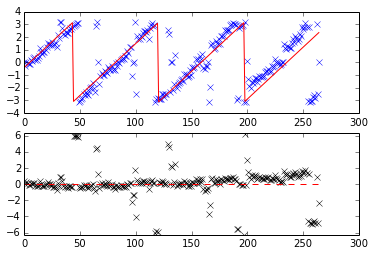

In [5]:
"""
Do a quick grid search of the best fit parameters

Uses the median of deviations to minimize, less sensitive to ~2pi wrapping outliers
"""

p1R, p1L = stitch(p1)
p2R, p2L = stitch(p2)

mask = np.linspace(0,8,8)*nchan

corr = np.fft.ifft( (np.fft.fft(p1R,axis=0) * np.conj(np.fft.fft(p2R, axis=0))), axis=0)

#data = np.angle(corr[0,3:-3, 2])
data = np.angle(corr[0])
data[0:nchan] = np.angle(np.conj(corr[0,:nchan]))
data[2*nchan:3*nchan] = np.angle(np.conj(corr[0,2*nchan:3*nchan]))
data[4*nchan:5*nchan] = np.angle(np.conj(corr[0,4*nchan:5*nchan]))
data[6*nchan:7*nchan] = np.angle(np.conj(corr[0,6*nchan:7*nchan]))

brange = np.linspace(0,2*np.pi,100)
mrange = np.linspace(-np.pi,np.pi,500)
x = np.linspace(0,len(data), len(data))

#data = np.delete(data, mask)
#x = np.delete(x, mask)

minfit = 1e10
for b in brange:
    for m in mrange:
        model = phase(x, m, b)
        mintemp = lsq(data, model)
        if mintemp < minfit:
            minfit = mintemp
            mbest = m
            bbest = b
            
print mbest, bbest

plt.subplot(211)
plt.plot(x, data, 'bx')
plt.plot(x, phase(x, mbest, bbest), 'r')

plt.subplot(212)
plt.plot(x, data-phase(x,mbest,bbest), 'kx')
plt.plot(x,0*x, 'r--')
plt.ylim(-2*np.pi, 2*np.pi)

(120, 180)

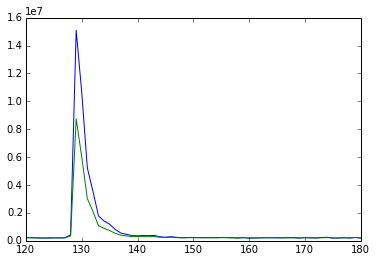

In [7]:
"""
Correct conjugates and sum incoherently
"""

pmodel = phase(x,mbest,bbest)
pmodel[0:nchan] *= -1
pmodel[2*nchan:3*nchan] *= -1
pmodel[4*nchan:5*nchan] *= -1
pmodel[6*nchan:7*nchan] *= -1

p2derot = p2R*np.exp(1j*pmodel)[np.newaxis,...]

pRsum = abs(p1R + p2derot)**2.0
pincoh = abs(p1R)**2.0 + abs(p2R)**2.0

plt.plot(pRsum.sum(-1))
plt.plot(pincoh.sum(-1))

plt.xlim(120,180)

-0.0692535454699 3.23679243097


(-6.283185307179586, 6.283185307179586)

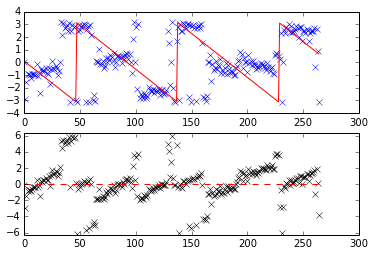

In [37]:
"""
Do a quick grid search of the best fit parameters

Uses the median of deviations to minimize, less sensitive to ~2pi wrapping outliers
"""

p1R, p1L = stitch(p1)
p2R, p2L = stitch(p2)

mask = np.linspace(0,8,8)*nchan

corr = np.fft.ifft( (np.fft.fft(p1L,axis=0) * np.conj(np.fft.fft(p2L, axis=0))), axis=0)

#data = np.angle(corr[0,3:-3, 2])
data = np.angle(corr[0])
data[0:nchan] = np.angle(np.conj(corr[0,:nchan]))
data[2*nchan:3*nchan] = np.angle(np.conj(corr[0,2*nchan:3*nchan]))
data[4*nchan:5*nchan] = np.angle(np.conj(corr[0,4*nchan:5*nchan]))
data[6*nchan:7*nchan] = np.angle(np.conj(corr[0,6*nchan:7*nchan]))

brange = np.linspace(0,2*np.pi,100)
mrange = np.linspace(-np.pi,np.pi,500)
x = np.linspace(0,len(data), len(data))

#data = np.delete(data, mask)
#x = np.delete(x, mask)

minfit = 1e10
for b in brange:
    for m in mrange:
        model = phase(x, m, b)
        mintemp = lsq(data, model)
        if mintemp < minfit:
            minfit = mintemp
            mbest = m
            bbest = b
            
print mbest, bbest

plt.subplot(211)
plt.plot(x, data, 'bx')
plt.plot(x, phase(x, mbest, bbest), 'r')

plt.subplot(212)
plt.plot(x, data-phase(x,mbest,bbest), 'kx')
plt.plot(x,0*x, 'r--')
plt.ylim(-2*np.pi, 2*np.pi)

(120, 180)

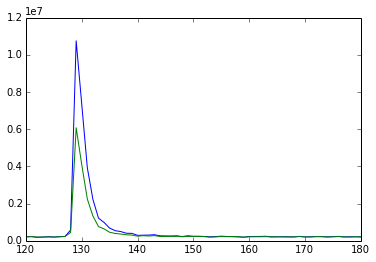

In [9]:
pmodel = phase(x,mbest,bbest)
pmodel[0:nchan] *= -1
pmodel[2*nchan:3*nchan] *= -1
pmodel[4*nchan:5*nchan] *= -1
pmodel[6*nchan:7*nchan] *= -1

p2derot = p2L*np.exp(1j*pmodel)[np.newaxis,...]

pLsum = abs(p1L + p2derot)**2.0
pincoh = abs(p1L)**2.0 + abs(p2L)**2.0

plt.plot(pLsum.sum(-1))
plt.plot(pincoh.sum(-1))

plt.xlim(120,180)

In [14]:
"""
Select telescope list, phase all pulses
"""

#t_gp = '2015-10-19T00:17:47.415'
t_gp = '2015-10-19T00:54:59.880'

tel1 = 'ef'
#tels = ['sr']
tels = ['jb','wb','hh','bd', 'sr', 'o8']
p1 = np.load('GP%s/p%s.npy' % (tel1, t_gp))
switch = 0

for tel in tels:

    p2 = np.load('GP%s/p%s.npy' % (tel, t_gp))
    
    """
    Shift timestreams to closest sample

    De-channelize, fit for corr peak, then shift
    """

    nchan = 32

    p1d = dechannelize(p1)
    p2d = dechannelize(p2)

    corr = np.fft.irfft( (np.fft.rfft(p1d,axis=0) * np.conj(np.fft.rfft(p2d, axis=0))), axis=0)
    sampdelay = np.argmax(abs(corr).sum(-1))
    p2d = np.roll(p2d, sampdelay, axis=0)

    p2 = channelize_ts(p2d, nchan)
    p1 = rechannelize(p1, nchan)

    """
    Do a quick grid search of the best fit parameters

    Uses the median of deviations to minimize, less sensitive to ~2pi wrapping outliers
    """

    p1R, p1L = stitch(p1)
    p2R, p2L = stitch(p2)

    if switch == 0:
        pRsum = 1.*p1R
        pincoh = abs(p1R)**2.0
        switch = 1
    
    mask = np.linspace(0,8,8)*nchan

    corr = np.fft.ifft( (np.fft.fft(p1R,axis=0) * np.conj(np.fft.fft(p2R, axis=0))), axis=0)

    data = np.angle(corr[0])
    data[0:nchan] = np.angle(np.conj(corr[0,:nchan]))
    data[2*nchan:3*nchan] = np.angle(np.conj(corr[0,2*nchan:3*nchan]))
    data[4*nchan:5*nchan] = np.angle(np.conj(corr[0,4*nchan:5*nchan]))
    data[6*nchan:7*nchan] = np.angle(np.conj(corr[0,6*nchan:7*nchan]))

    brange = np.linspace(0,2*np.pi,100)
    mrange = np.linspace(-np.pi,np.pi,500)
    x = np.linspace(0,len(data), len(data))

    minfit = 1e10
    for b in brange:
        for m in mrange:
            model = phase(x, m, b)
            mintemp = lsq(data, model)
            if mintemp < minfit:
                minfit = mintemp
                mbest = m
                bbest = b

    """
    Correct conjugates and sum incoherently
    """

    pmodel = phase(x,mbest,bbest)
    pmodel[0:nchan] *= -1
    pmodel[2*nchan:3*nchan] *= -1
    pmodel[4*nchan:5*nchan] *= -1
    pmodel[6*nchan:7*nchan] *= -1

    p2derot = p2R*np.exp(1j*pmodel)[np.newaxis,...]

    pRsum += p2derot
    pincoh += abs(p2R)**2.0

plt.plot((abs(pRsum)**2.0).sum(-1))
plt.plot(pincoh.sum(-1))

#plt.xlim(120,180)


In [16]:
print pRsum.shape

test = np.delete(pRsum, np.linspace(0,8,8)*(nchan+1), axis=1)

pfine = rechannelize(test, 256*8)

%matplotlib qt
plt.subplot(211)
plt.plot((abs(pfine)**2.0).sum(-1))

plt.subplot(212)
plt.plot(abs(pfine[16])**2.0)
plt.plot(abs(pfine[18])**2.0, 'r')

(256, 264)


In [27]:
#corrb = 1.*np.array(corr)
corr = []
corrb = []

p1t = abs(pfine[16])**2.0
p2t = abs(pfine[18])**2.0
p1b = abs(pfine[14])**2.0
p2b = abs(pfine[20])**2.0


for i in range(len(p1t)):
    p2temp = np.roll(p2t, i)
    b2temp = np.roll(p2b, i)
    corr.append(np.sum(p1t*p2temp))
    corrb.append(np.sum(p1b*b2temp))

%matplotlib qt
corr = np.array(corr)
corrb = np.array(corrb)

plt.plot(np.roll(corr, 1024))
plt.plot(np.roll(corrb, 1024) * 50, 'r')


2.52276749814 0.170597243113 2.2213281389 0.169985975244


(-6.283185307179586, 6.283185307179586)

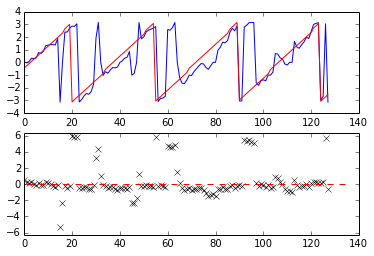

In [146]:
import scipy.optimize as so

p0 = [mbest, bbest]

bestfit = so.curve_fit(phase, x, data, p0)[0]
bfit = bestfit[1]
mfit = bestfit[0]

print bfit, mfit, bbest, mbest

plt.subplot(211)
plt.plot(data, 'b')
plt.plot(phase(x, mfit, bfit), 'r')

plt.subplot(212)
plt.plot(data-phase(x,mfit,bfit), 'kx')
plt.plot(x,0*x, 'r--')
plt.ylim(-2*np.pi, 2*np.pi)